# Scope of this NoteBook:

In this notebook we study different techniques to perform time series analysis.
The main usecase we have here is to predict the closing price of Apple given the previous X prices.
We will compare different models, different hyperparameters and we willalso compare different observables.

The datacleaning and gathering and the LSTM model architecture is done following [link](https://www.youtube.com/watch?v=QIUxPv5PJOY), the exploration of the different batch sizes, the comparison with simpler model and with Fourier transforms and the Returns studies have been done by myself.

I would like to aknowledge useful discussions with P Mattioli and G Minneci.

In [1]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import math

/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Downloading the data

We will use DataReader (provided by PanDas) to download the data.
We will choose the followings:
1. Apple prices (AAPL)
2. Yahoo finance as a source
3. The starting point as first of january 2012
4. The final point as December 17th 2019

In [2]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970


In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2003.000000,2003.000000,2003.000000,2003.000000,2.003000e+03,2003.000000
mean,127.194100,124.954538,126.079166,126.109797,5.960691e+07,119.389611
std,50.028310,49.234509,49.592770,49.679272,4.688887e+07,51.745687
min,57.085712,55.014286,55.424286,55.790001,1.136200e+07,49.142811
25%,86.649998,84.915001,85.766430,85.971428,2.760790e+07,75.313698
50%,114.019997,111.660004,112.820000,112.919998,4.369990e+07,105.513168
75%,165.939995,162.125000,163.845001,163.970001,7.482090e+07,158.767662
max,281.769989,278.799988,279.570007,280.410004,3.765300e+08,279.746094


### Plotting the data

Before to study any model, we will plot the data.
We are interested in the closing prices of the  stock represented by the column 'Close'

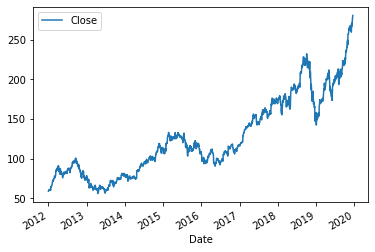

In [5]:
df.plot(y = 'Close')

### Isolate the data

We want to predict the closing prices given the history of the same quantity.
We can then isolate them creating a new dataframe.
We convert then it to numpy

In [6]:
df_cp = pd.DataFrame(df['Close'])

In [7]:
df_cp

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143
...,...
2019-12-11,270.769989
2019-12-12,271.459991
2019-12-13,275.149994


In [8]:
data = df_cp.to_numpy()

In [9]:
data

array([[ 58.74714279],
       [ 59.06285858],
       [ 59.71857071],
       ...,
       [275.1499939 ],
       [279.85998535],
       [280.41000366]])

## Train Test Split

It is now time to prepare to train the model, this means that we need to split out data into *train* and *test* sets.
We create a helper function to perform this without shuffling the data, we want to preserve our time series and use the data before a certain date to tain our model and then to use the data after that date to test it in order to observe how much it can look into the future.

In [10]:
def train_test_split(dataset, percentage=0.8):
    return dataset[:math.ceil(len(dataset)*percentage)], dataset[math.ceil(len(dataset)*percentage):] 

In [11]:
train_dataset, test_dataset = train_test_split(data)

In [12]:
print(len(train_dataset),
len(test_dataset),
len(data))

1603 400 2003


## Scale the data

Many models require their inputs to be properly normalized, machine learning models are no exception.
We are going to use the sklearn MinMaxScaler to normalize the interval setting the minimum value to zero and the maximum value to 1, we are not imposing any statistics to the data as we would do using a norma scaler or something similar.

It is important to notice that the normalization is done just on the *train* set, if we do it on the entire dataset we are going to pour some of the information of the *test* into the *train*, which is something we do not want.

**NB** The video I cited in the beginning was using the entire dataset to normalize its data, making there a quite big mistake.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
# We then define the scaler and we apply it
scaler = MinMaxScaler()
scaler.fit(train_dataset)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
# We create a new scaled dataset
scaled_train = scaler.transform(train_dataset)

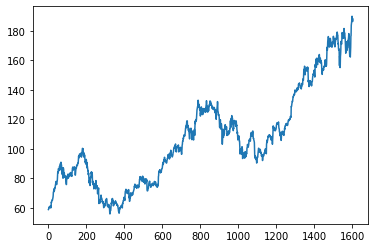

In [16]:
plt.plot(train_dataset)

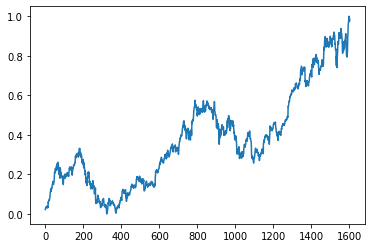

In [17]:
# We observe how it is  in between0 and 1
plt.plot(scaled_train)

In [18]:
# We now rescale the test
scaled_test = scaler.transform(test_dataset)

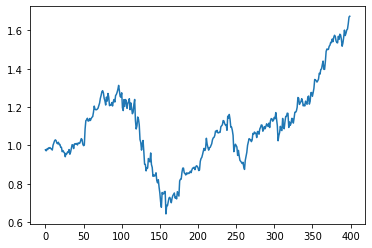

In [19]:
# We plot it
plt.plot(scaled_test)

# LSTM in Keras

One of the most known and widely used models to perform time series analysis is the Long Short Term Memory.
The success of this model is due to its capacity of keeping memory of both long and short term dependencies, and also to avoid the vanishing gradient problem.
We are going to use the model to extract informations and predict the next prices, the scheme of the model is the following:
1. 2 LSTM layers are used to extract features from the time series, each of them has a hidden dimension of 50
2. The features are the run through a dense layer, which compresses the information to 25
3. The final result is predicted from the prevousily compressed features

The model is trained optimizing the $L_2$ losses on the target value which we feed in to supervise the learning.
The optimizer used is ADAM and we train for a total of 20 epochs.

In [24]:
import keras

Using TensorFlow backend.


In [84]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(50, return_sequences=True, input_shape = (60, 1)))
    model.add(keras.layers.LSTM(50, return_sequences=False))
    model.add(keras.layers.Dense(25, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss = 'mse')
    return model

## Creation of the  training data

We need now to rewrite the dataset in a way that it is suitable to train our model.

General models for sequences analysis require their input to be something like:
*$ \left[ \text{Batch size}, \text{Sequence Length}, \text{Input Features} \right] $*

We are going to manipulate the dataset to be rewritten as:
*$\left[ \text{Elements in the Dataset}, \text{Values} \right] \rightarrow \left[ \text{Elements in the dataset} - \text{Seq}, \text{Seq}, 1 \right]$*

for the input. The output is going to be rewritten as:

*$\left[ \text{Elements in the dataset} - \text{Seq}, \text{Seq}, 1 \right]$*

In [20]:
def create_training_data(train_dataset, Seq):
    final_input = []
    result = []
    for t in range(Seq, len(train_dataset)):
#         at each time t we select the previous Seq values and we get as result t
        final_input.append(train_dataset[t-Seq:t])
        result.append(train_dataset[t])
    return np.asarray(final_input), np.asarray(result)

In [21]:
train_data, train_target = create_training_data(scaled_train, 60)

In [22]:
# Shape check
train_data.shape

(1543, 60, 1)

In [100]:
train_target.shape

(1543, 1)

### Large vs Small batch size

In many techniques used to predict the time evolution there is an explicit or implicit averaging over some frequencies.
Usually the large frequencies, responsible for rapid oscillations are the ones that are more affected by these averaging resulting in smoother signals.

The LSRM architecture does not have any explicit fitlering, we will see that this effect is provided by the Batch Size.

In [85]:
small_batch_size = get_model()

In [86]:
large_batch_size = get_model()

### The training loop

We are going now to train the small_batch_size model with BS = 4, meaning that its weights are updated after each group od 4 sequences, while the large batch size model will be trained using a batch size of 128.

In [87]:
small_batch_size.fit(train_data, train_target, batch_size=4, epochs=20)

Epoch 1/20
1543/1543 [==============================] - 33s 21ms/step - loss: 0.0027
Epoch 2/20
1543/1543 [==============================] - 28s 18ms/step - loss: 0.0010
Epoch 3/20
1543/1543 [==============================] - 15s 10ms/step - loss: 9.1377e-04
Epoch 4/20
1543/1543 [==============================] - 15s 10ms/step - loss: 6.6905e-04
Epoch 5/20
1543/1543 [==============================] - 19s 12ms/step - loss: 5.6478e-04
Epoch 6/20
1543/1543 [==============================] - 19s 12ms/step - loss: 4.2297e-04
Epoch 7/20
1543/1543 [==============================] - 20s 13ms/step - loss: 5.0112e-04
Epoch 8/20
1543/1543 [==============================] - 20s 13ms/step - loss: 3.6032e-04
Epoch 9/20
1543/1543 [==============================] - 20s 13ms/step - loss: 3.6967e-04
Epoch 10/20
1543/1543 [==============================] - 24s 15ms/step - loss: 3.3509e-04
Epoch 11/20
1543/1543 [==============================] - 24s 16ms/step - loss: 2.9154e-04
Epoch 12/20
1543/1543 [====

In [88]:
large_batch_size.fit(train_data, train_target, batch_size=128, epochs=20)

Epoch 1/20
1543/1543 [==============================] - 2s 2ms/step - loss: 0.0808
Epoch 2/20
1543/1543 [==============================] - 1s 786us/step - loss: 0.0089
Epoch 3/20
1543/1543 [==============================] - 1s 792us/step - loss: 0.0029
Epoch 4/20
1543/1543 [==============================] - 1s 792us/step - loss: 0.0013
Epoch 5/20
1543/1543 [==============================] - 1s 871us/step - loss: 0.0012
Epoch 6/20
1543/1543 [==============================] - 1s 794us/step - loss: 0.0011
Epoch 7/20
1543/1543 [==============================] - 2s 1ms/step - loss: 0.0010
Epoch 8/20
1543/1543 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 9/20
1543/1543 [==============================] - 2s 1ms/step - loss: 0.0012
Epoch 10/20
1543/1543 [==============================] - 1s 851us/step - loss: 0.0010
Epoch 11/20
1543/1543 [==============================] - 1s 872us/step - loss: 0.0010
Epoch 12/20
1543/1543 [==============================] - 2s 1ms/step - 

### Testing the models

We can alredy see that there is a relative difference between the training losses of the two models.
We can see how their generalization errors are drastically difference, with an order of magnitude of difference.
The small batch size model has a much higer capability to predict the unseen data, meaning that it generalizes better.

In [105]:
# We rewrite the test dataset in a way suitable to be inputted into the model
test_data, test_target = create_training_data(scaled_test, 60)

In [106]:
small_batch_size.evaluate(x=test_data, y=test_target)

340/340 [==============================] - 0s 562us/step


0.0010427678524352172

In [108]:
large_batch_size.evaluate(x = test_data, y = test_target)

340/340 [==============================] - 0s 519us/step


0.010794480758554796

### Predictions comparison

We have an idea about how much the two models differ in predicting unseen values.
We want now to proceed and study *how* they are different, in order to do so we are going to plot them against the true ones.

In [110]:
prediction_small_batch = small_batch_size.predict(test_data)
prediction_large_batch = large_batch_size.predict(test_data)

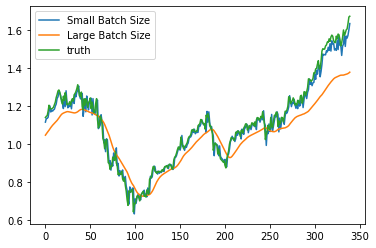

In [111]:
plt.plot(prediction_small_batch, label = 'Small Batch Size')
plt.plot(prediction_large_batch, label = 'Large Batch Size')
plt.plot(test_target, label = 'truth')
plt.legend()
plt.show()

#### Un-Normalize the data

The data presented before are still using the noramlized input, we can use the scaler we defined before to un-normalize them and see the predictions in the correct scale.

In [95]:
prediction_small_bs = scaler.inverse_transform(prediction_small_batch)
prediction_large_bs = scaler.inverse_transform(prediction_large_batch)

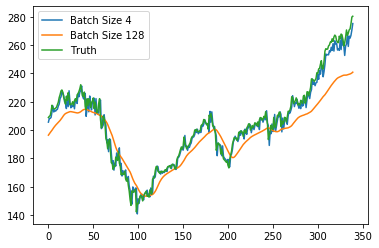

In [112]:
plt.plot(prediction_small_bs, label = 'Batch Size 4')
plt.plot(prediction_large_bs, label = 'Batch Size 128')
plt.plot(test_dataset[60:], label = 'Truth')
plt.legend()
plt.show()

### Frequencies Filtering effects

We can see how the small batch size is much more responsive to fast changes in the prices, while the larg batch size one is learning mainly learning the slow moving features.

it has to be noticed that the features learnt by the small batch size model comes with the price of a much longer training time on the CPU.

# A very simple model

We can then compare our results for the time series against the simpler model possible.
In order to  predict the value of the point $ x\left[ t+1 \right] $ we use a linear interpolation of the previous two:
$ x\left[ t+1 \right] = 2 x\left[ t \right] - x\left[ t-1 \right]$.
This model will provide a baseline we would run against using our LSTM model build in Keras.

In [113]:
# Another simple model
def model(seq):
#     We simply use a stupid regression
#     x[t+1] = 2*x[t]-x[t-1]
    result = []
    for i in range(2, len(seq)):
        result.append(2.*seq[i-1]-seq[i-2])
    return np.asarray(result)

In [116]:
# This model does not have any ned to receive normalized inputs
simple_pred = model(test_dataset)

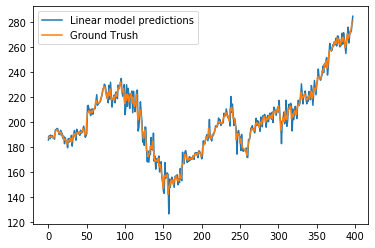

In [117]:
plt.plot(simple_pred, label = 'Linear model predictions')
plt.plot(test_dataset[2:], label = 'Ground Trush')
plt.legend()
plt.show()

### Comparing the models

We have now two models, we want now to understand which of them performs better after training.

Clearly, we expect our simple model to perform the worst, but we need a quantitative way to say what is best and what is worst.
We then use the R2 score, again provided by the sklearn library, to compute the score on the test set.

In [121]:
from sklearn.metrics import r2_score

In [43]:
r2_score(test_dataset[2:], simple_pred)

0.9693919759437924

In [119]:
r2_score(test_dataset[60:], prediction_small_bs)

0.9786200671047295

In [120]:
r2_score(test_dataset[60:], prediction_large_bs)

0.7786800794457547

### Results comparison

The R2 score is quantitatively measuring the results of the models on the test dataset.
The simple model obtains an excellent score, the large batch size model on the other side struggles a lot while the small batch sizes model beats them all, which is not surprising due to its longer training time.

## Fourier Series

We can now use another way to predict the time evolution of our time series: Fourier Series.

The idea is to use the training set to compute the Fourier coefficients of out signal, then we will use these Fourier coefficients to perform interpolation on the test signal and see how accuracte this model is.

In [45]:
import scipy

In [46]:
# We compute the Fourier series
coefficients = np.fft.fft(scaled_train.reshape(len(scaled_train)))

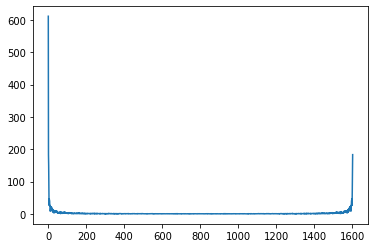

In [47]:
plt.plot(np.absolute(coefficients))

In [48]:
def filter_and_rescale(coef, low_filter = 0., high_filter = 0.):
    coef[coef<0.5] = 0
    low_lim = int(len(coef)*low_filter)
    high_lim = int(len(coef)*(1-high_filter))
    result = np.concatenate((np.zeros(low_filter), coef[low_lim:high_lim], np.zeros(len(coef)-high_lim)))
    assert len(result) == len(coef)
    return result

In [49]:
fft = filter_and_rescale(coefficients, low_filter=0, high_filter=0.)

In [50]:
len(fft)

1603

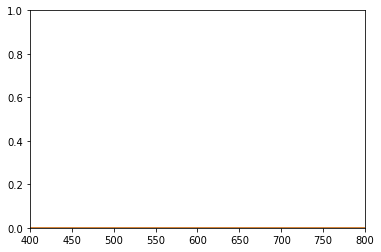

In [51]:
plt.xlim([400,800])
plt.ylim([0,1])
plt.plot(np.absolute(coefficients))
plt.plot(np.absolute(fft))
plt.show()

In [52]:
fft_pred = np.fft.ifft(coefficients, len(scaled_train))
fft_filter = np.fft.irfft(fft, len(scaled_train))

In [53]:
fft_pred = np.fft.irfft(coefficients, len(scaled_train)+len(scaled_test))
fft_filter = np.fft.irfft(np.pad(fft,(0, len(scaled_test)//2)))

In [54]:
def time_evolution(coeff, init_time):
    freq = np.fft.fftfreq(coeff.size, d=1)
    coeff  = np.multiply(coeff, np.exp(1.0j*freq*init_time))
    return coeff

In [55]:
t_evolved = time_evolution(fft, 0)

In [56]:
evo = np.fft.ifft(t_evolved, len(scaled_train))

/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


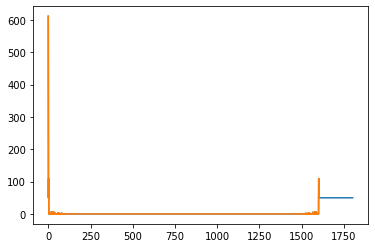

In [57]:
plt.plot(np.pad(fft, (0, len(scaled_test)//2), mode = 'edge'))
plt.plot(fft)

In [58]:
print(len(evo))
print(len(scaled_train))
print(len(scaled_test))

1603
1603
400


/home/lorenzo/Documents/learning/TimeSeriesTutorial/.LSTM/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

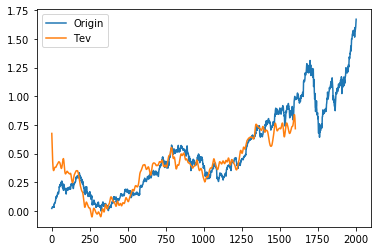

In [59]:
plt.plot(np.concatenate((scaled_train,scaled_test)), label = 'Origin')
plt.plot(evo, label = 'Tev')
# plt.plot(scaled_train, label = 'Orig')
# plt.plot(np.absolute(fft_pred))
# plt.plot(fft_pred)
plt.legend()
plt.plot()

### Returns

We use the models we have derived before, the simple and the LSTM, to predict the returns, defined as

*$
f(x) = \frac{x[t+1]-x[t]}{x[t]}
$*

We start creating an helper function to compute  the returns starting from the closing prices.

In [60]:
def compute_return(closing):
    m = np.diff(closing, axis = 0)
    return m/closing[:-1]

In [61]:
predicted_returns = compute_return(prediction)

In [62]:
true_returns = compute_return(test_dataset[60:])

In [63]:
predicted_returns.reshape(340,1,1)

ValueError: cannot reshape array of size 339 into shape (340,1,1)

In [ ]:
len(predicted_returns)

In [ ]:
true_returns.shape

In [ ]:
r2_score(true_returns, predicted_returns)

In [ ]:
plt.plot(true_returns)
plt.plot(predicted_returns)
plt.show()

In [ ]:
def filter(x, w):
    df = pd.DataFrame(x)
    df = df.rolling(w).mean()
    df = df.dropna()
    return df.to_numpy()

In [ ]:
filtered_test = filter(test_dataset[60:], 10)

In [ ]:
len(filtered_test)

In [ ]:
plt.plot(prediction[10:])
plt.plot(filtered_test)
plt.show()

In [ ]:
true_returns = compute_return(filtered_test)

In [ ]:
plt.plot(true_returns)
plt.plot(predicted_returns[9:])
plt.show()

In [ ]:
r2_score(true_returns, predicted_returns[9:])

In [ ]:
simple_returns  = compute_return(simple_pred)

In [ ]:
true_returns = compute_return(test_dataset)
r2_score(true_returns[2:], simple_returns)

In [ ]:
# plt.plot(true_returns[2:])
# plt.plot(simple_returns)
plt.plot(np.abs(simple_returns-true_returns[2:]))
plt.show()

In [ ]:
zero_model = np.zeros(len(test_dataset))

In [ ]:
r2_score(true_returns, zero_model[1:])